In [1]:
import numpy as np
import time
from glob import glob
from natsort import natsorted
from skimage.measure import label
from skimage.segmentation import relabel_sequential
import matplotlib.pyplot as plt

from metrics import evaluate 
from utils import *
import cv2, os

In [2]:
meds = ["acis", "graphcl", "rec", "maskrcnn"]
len_test = 25

In [19]:
acis_path = natsorted (glob ('/home/tuan/256_acis_master/eval/cvppp/results/*_label.png'))
graphcl_path = natsorted (glob ('/home/tuan/GraphCL3D/deploy/160_cremi/test/*.tif')) [:len_test]
rec_path = natsorted (glob ('/home/tuan/rec-attend-public-all/rec-cremi-160/results/full_model_cvppp-20200820105951/output_valid/30/*.png')) [:len_test]
maskrcnn_path = natsorted (glob ('/home/tuan/Mask_RCNN/results/cremi_160/submit_20200830T075210/*.tif')) [:len_test]

gt_path = natsorted (glob ('/home/tuan/Data/Cremi/Corrected/160/test/B/*.tif'))
em_path = natsorted (glob ('/home/tuan/Data/Cremi/Corrected/160/test/A/*.tif'))

In [20]:
acis = [io.imread (pth) for pth in acis_path]
graphcl = [io.imread (pth) for pth in graphcl_path]
rec = [io.imread (pth) for pth in rec_path]
print (rec [0].shape)
rec = [(img [...,0] * (256 ** 2)).astype (np.int32) + img [...,1] * 256 + img [...,2] for img in rec]
rec = [relabel_sequential (img) [0] for img in rec]
maskrcnn = [io.imread (pth) for pth in maskrcnn_path]
em =  [io.imread (pth) for pth in em_path]
gt = [io.imread (pth) for pth in gt_path]

(160, 160, 3)


In [21]:
gt_median_sizes = [np.median (np.unique (img, return_counts=True)[1]) for img in gt]
print (gt_median_sizes)

[996.0, 1710.0, 252.5, 928.0, 1853.0, 1104.0, 1265.5, 950.5, 710.0, 785.0, 545.5, 2296.0, 1316.5, 899.0, 763.0, 1209.0, 1283.0, 467.0, 1537.0, 2320.0, 3449.5, 705.0, 369.5, 1184.0, 822.0]


In [22]:
paths = [acis_path, graphcl_path, rec_path, maskrcnn_path]
res = [acis, graphcl, rec, maskrcnn]

In [23]:
#Post-processing GraphCL
metrics = ["bestDice", "rand_i", "voi_split", "voi_merge", "adapted_rand", "AJI"]
minsize = 100
scores = np.zeros (len (metrics))

post_processed = []
post_proc_time = 0

for i in range (len_test):
    curtime = time.time ()
    pred_lbl = label (graphcl [i])
    gt_lbl = gt [i]
    pred_lbl = relabel_sequential (clean (pred_lbl, minsize)) [0]
    post_processed += [pred_lbl]
    post_proc_time += time.time () - curtime
    
    size = gt_lbl.shape
    pred_lbl = cv2.resize (pred_lbl.astype (np.int32), size, interpolation=cv2.INTER_NEAREST)
    
    scores += np.array (evaluate (pred_lbl, gt_lbl))

avg_post_proc_time = post_proc_time / len_test
scores /= len_test
    
for met, score in zip (metrics, scores):
    print (met, ":\t", score)
print ("Post processing time: ", avg_post_proc_time)

bestDice :	 0.830469336955776
rand_i :	 0.9219635845103816
voi_split :	 0.24831380430733876
voi_merge :	 0.13577856955315348
adapted_rand :	 0.034375915805451095
AJI :	 0.8059136861468518
Post processing time:  0.00328639030456543


In [24]:
graphcl = post_processed

In [25]:
tmp = []
for med, met, lbl_lists in zip (meds, metrics, res):
    if med == 'graphcl':
        continue
    scores = np.zeros (len (metrics))
    for i in range (len_test):
        gt_lbl = gt [i]
        pred_lbl = relabel_sequential (lbl_lists [i]) [0]
        size = gt_lbl.shape
        pred_lbl = cv2.resize (pred_lbl.astype (np.int32), size, interpolation=cv2.INTER_NEAREST)
        scores += np.array (evaluate (pred_lbl, gt_lbl))
        lbl_lists [i] = pred_lbl
    tmp += [lbl_lists]
    scores /= len_test
    print (med)
    for met, score in zip (metrics, scores):
        print (met, ":\t", score)
    print ('-' * 60)
acis, rec, maskrcnn = tmp

acis
bestDice :	 0.8482964423201085
rand_i :	 0.7888661509598252
voi_split :	 0.4200807483482645
voi_merge :	 0.3950626790140984
adapted_rand :	 0.13476274335884308
AJI :	 0.542346891204588
------------------------------------------------------------
rec
bestDice :	 0.6203209439406311
rand_i :	 0.7938798966284893
voi_split :	 0.46342167476093576
voi_merge :	 0.3945907487057074
adapted_rand :	 0.12917943652408673
AJI :	 0.5598027399707868
------------------------------------------------------------
maskrcnn
bestDice :	 0.6587168189132346
rand_i :	 0.6667356596226856
voi_split :	 0.8565983894688892
voi_merge :	 0.35419076722155085
adapted_rand :	 0.23946043015855384
AJI :	 0.6460974371049687
------------------------------------------------------------


In [26]:
acis, rec, maskrcnn = tmp
    

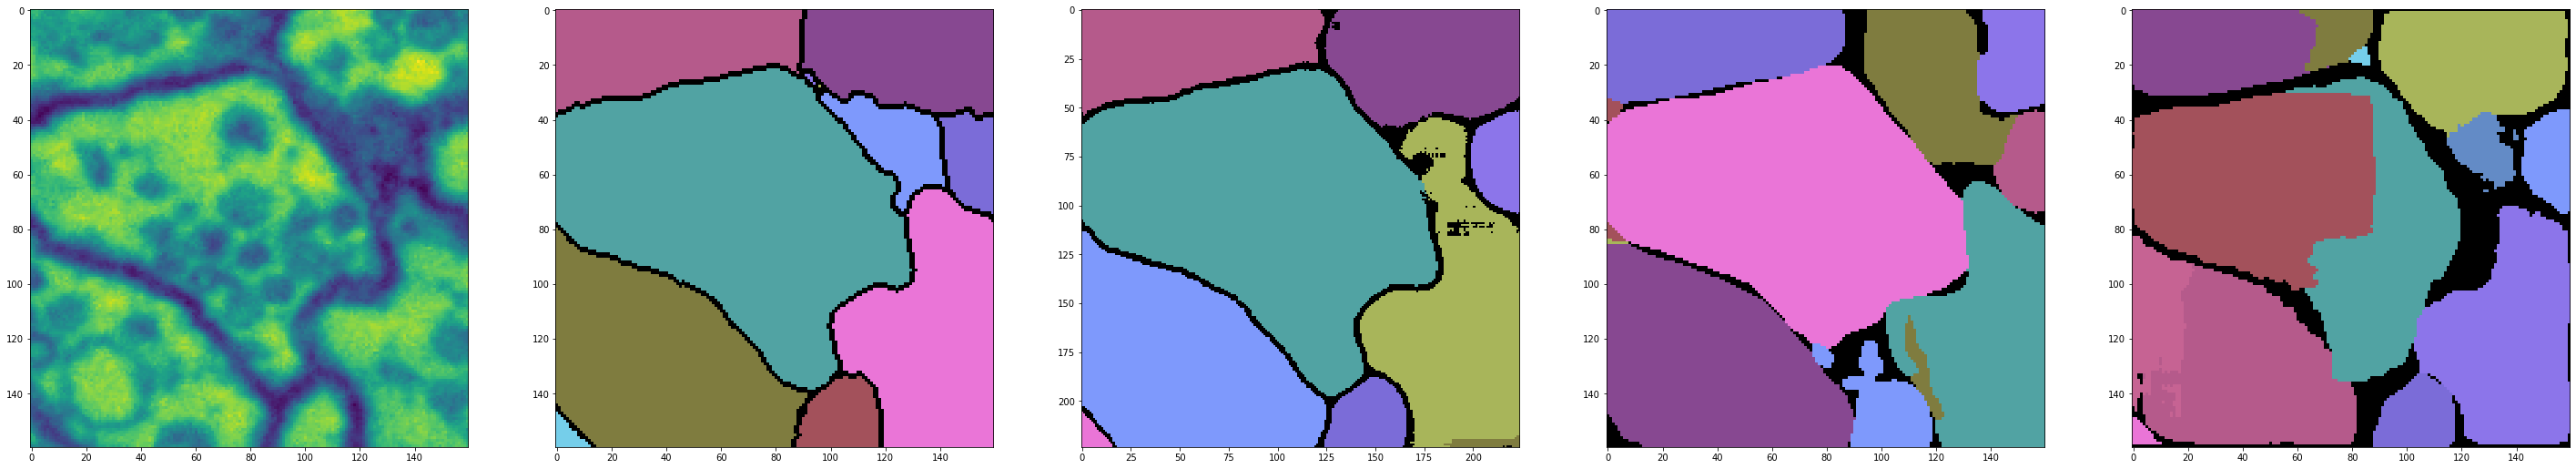

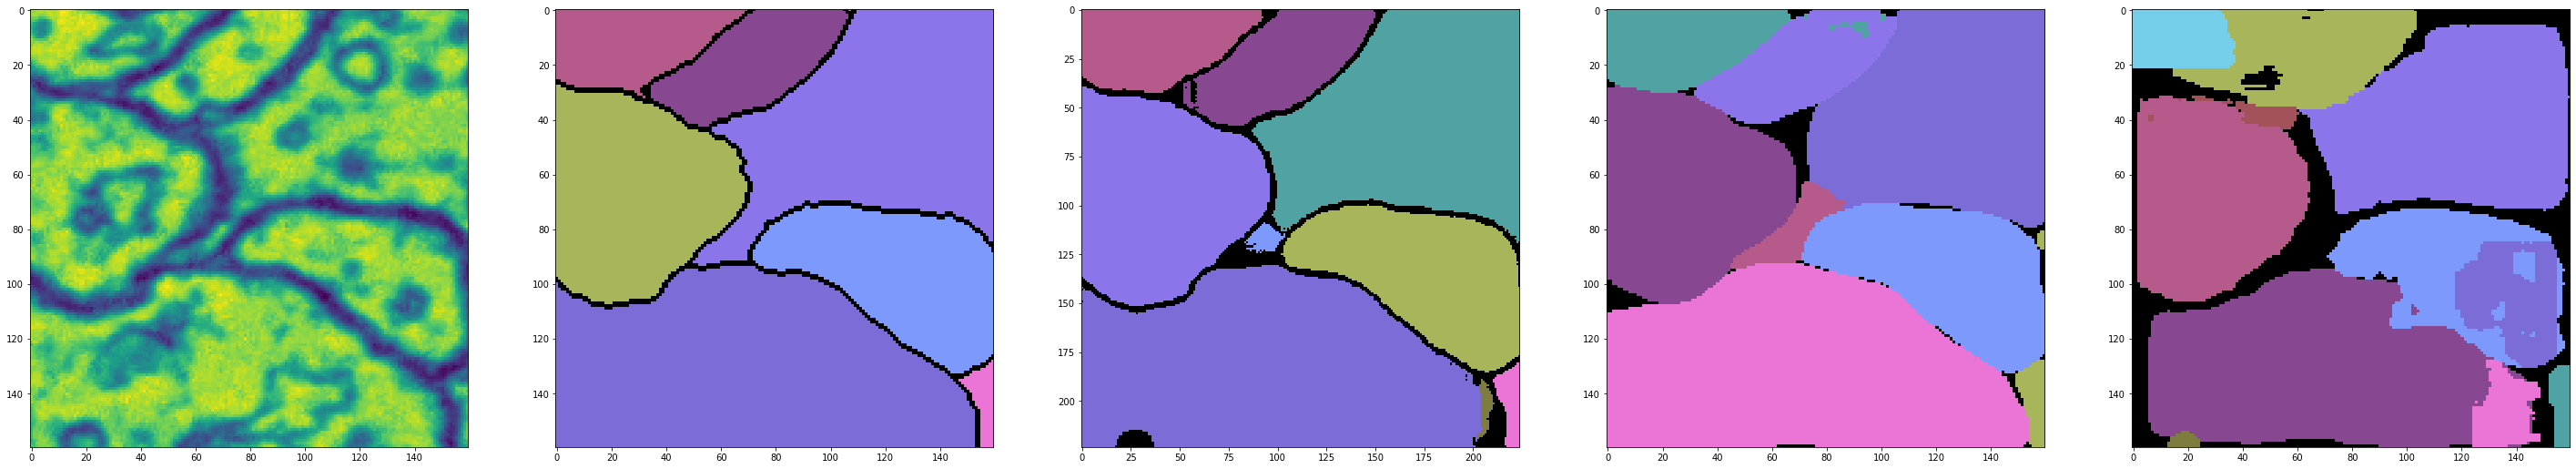

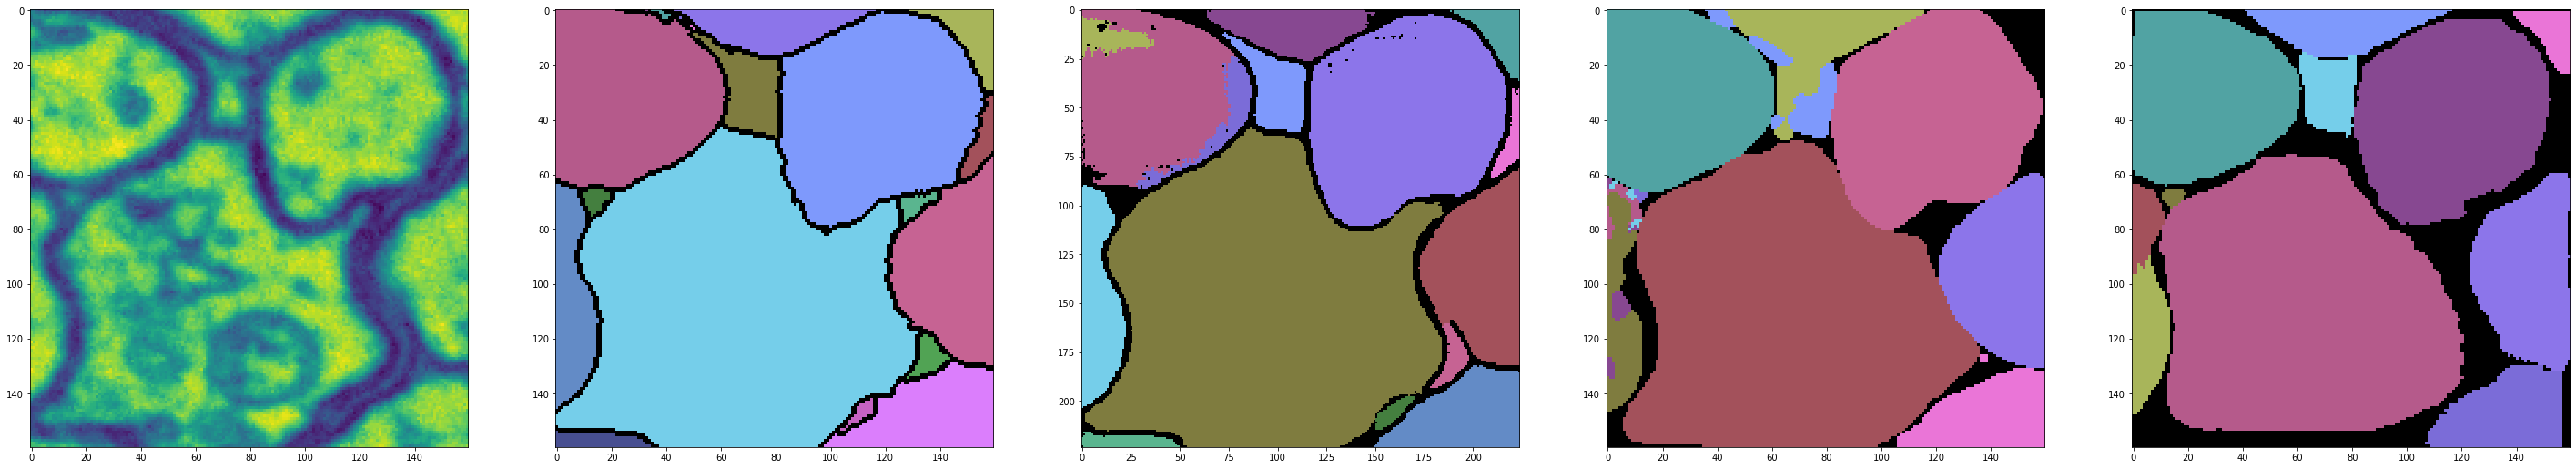

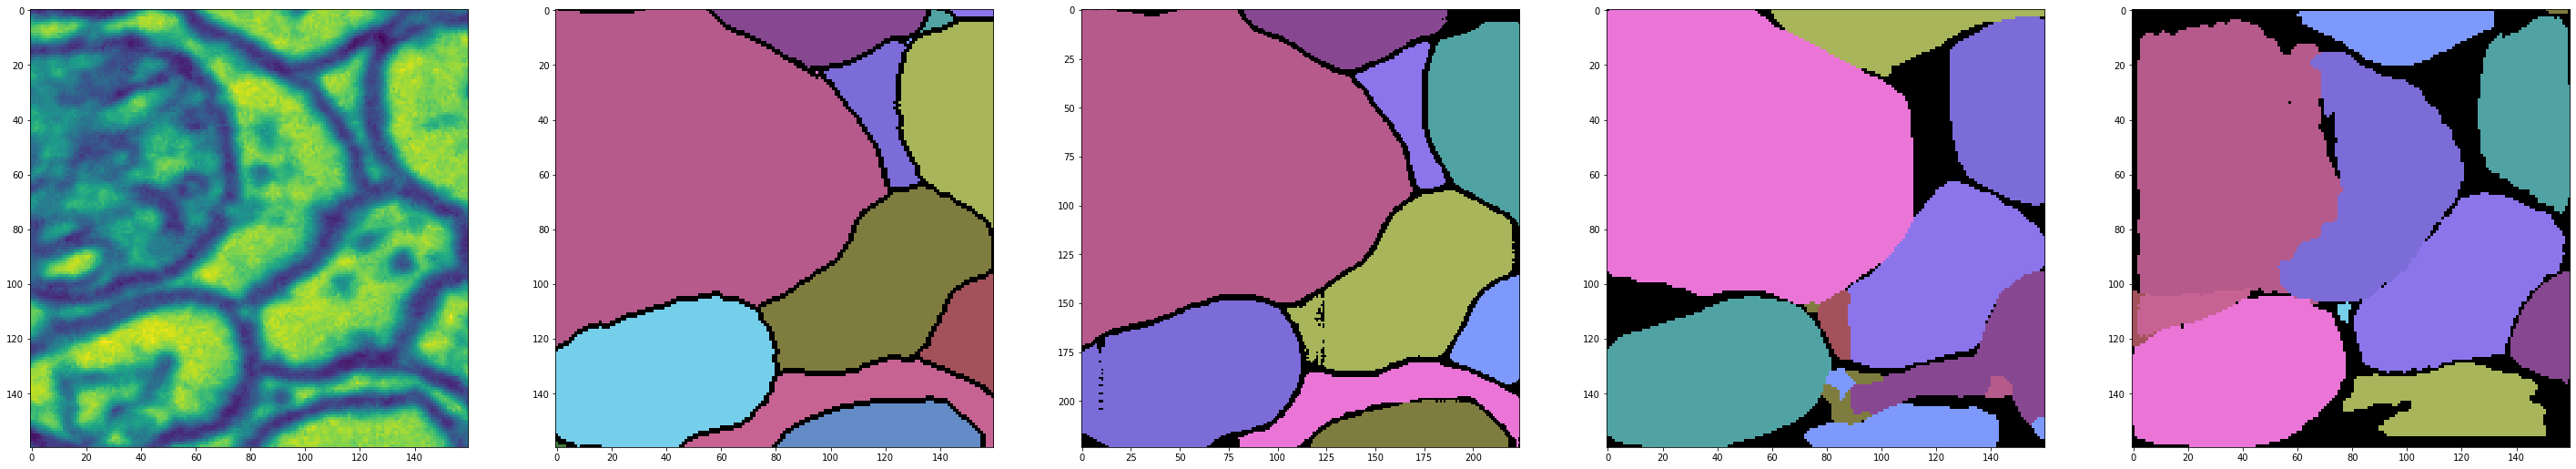

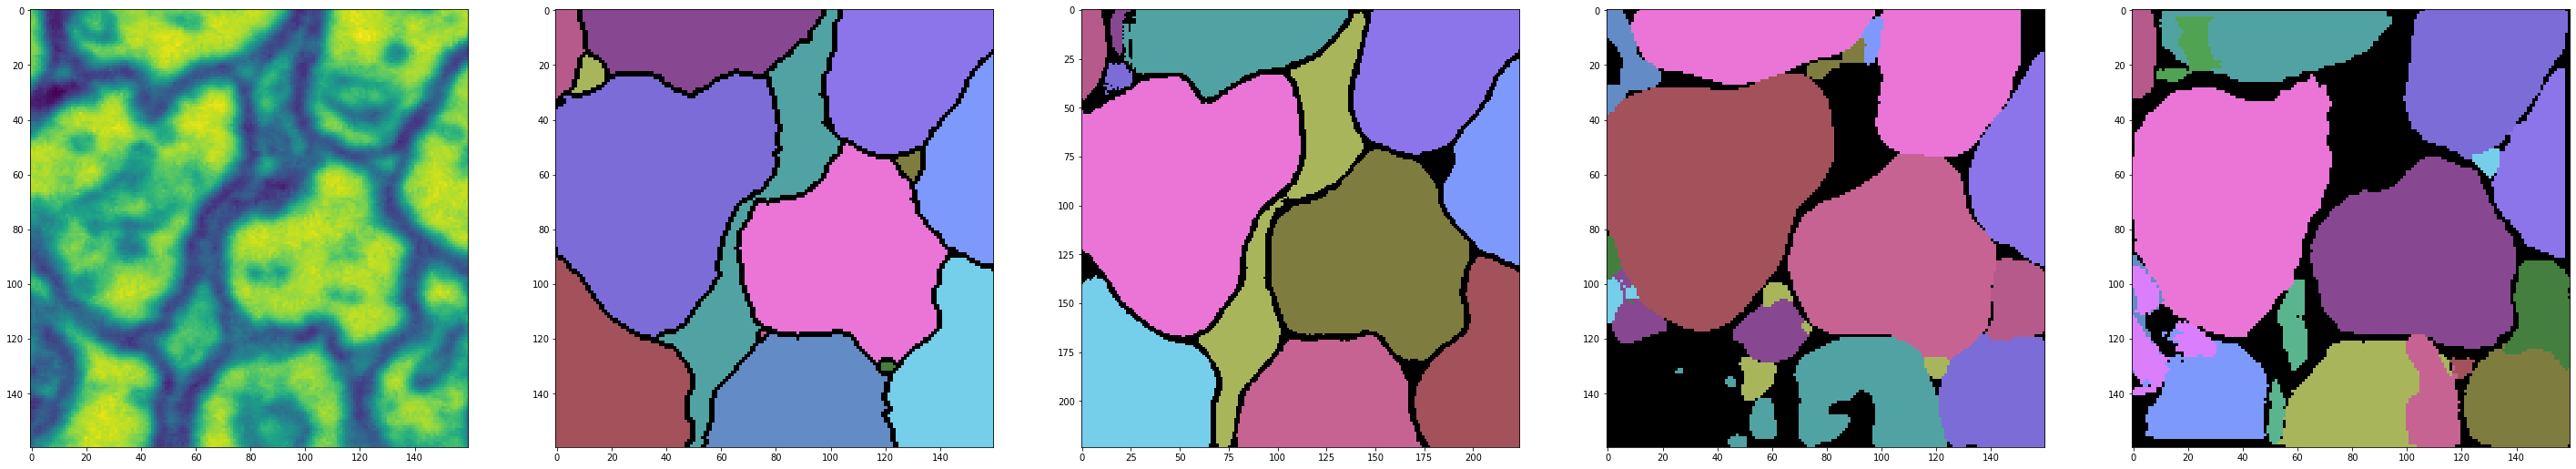

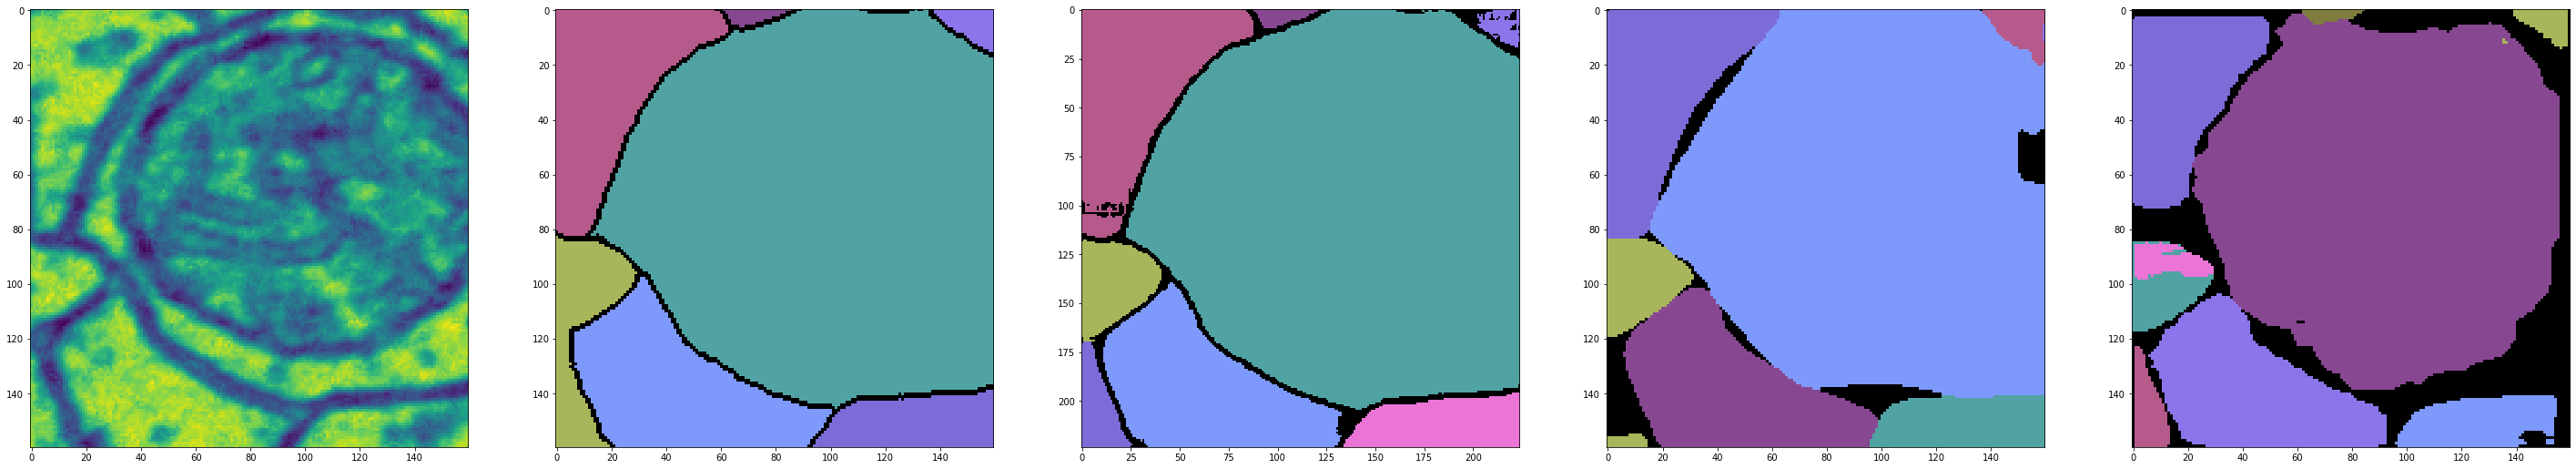

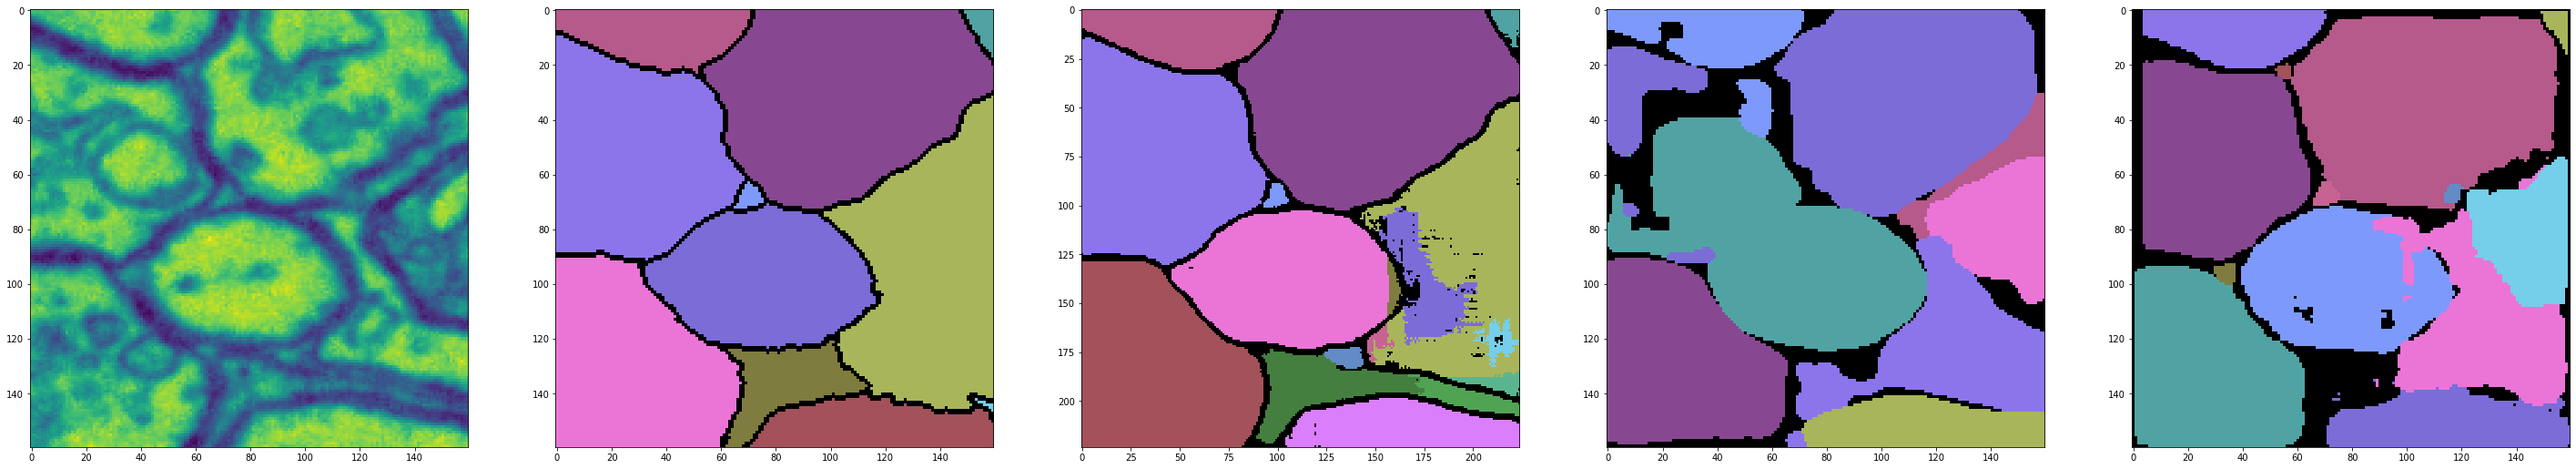

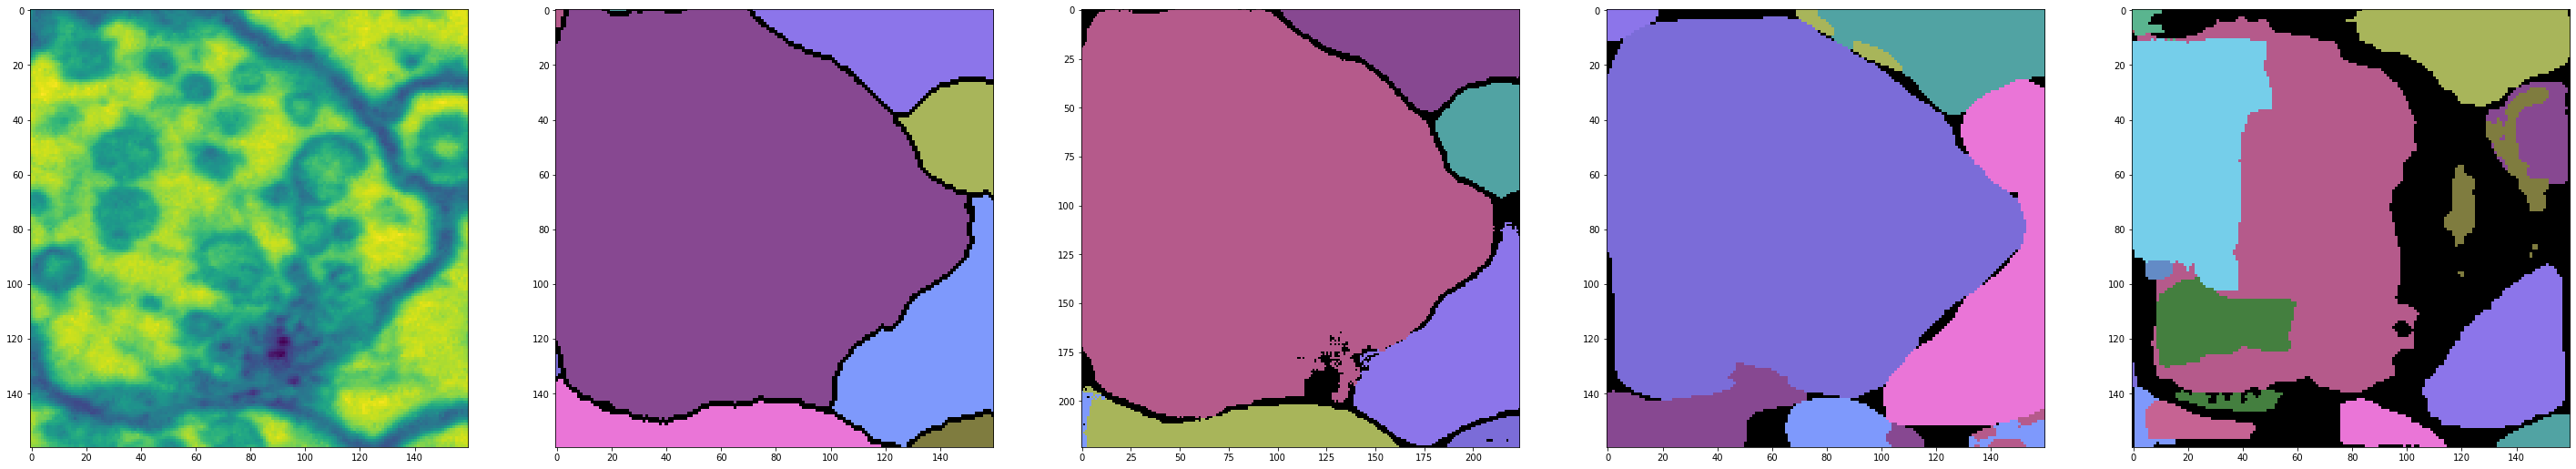

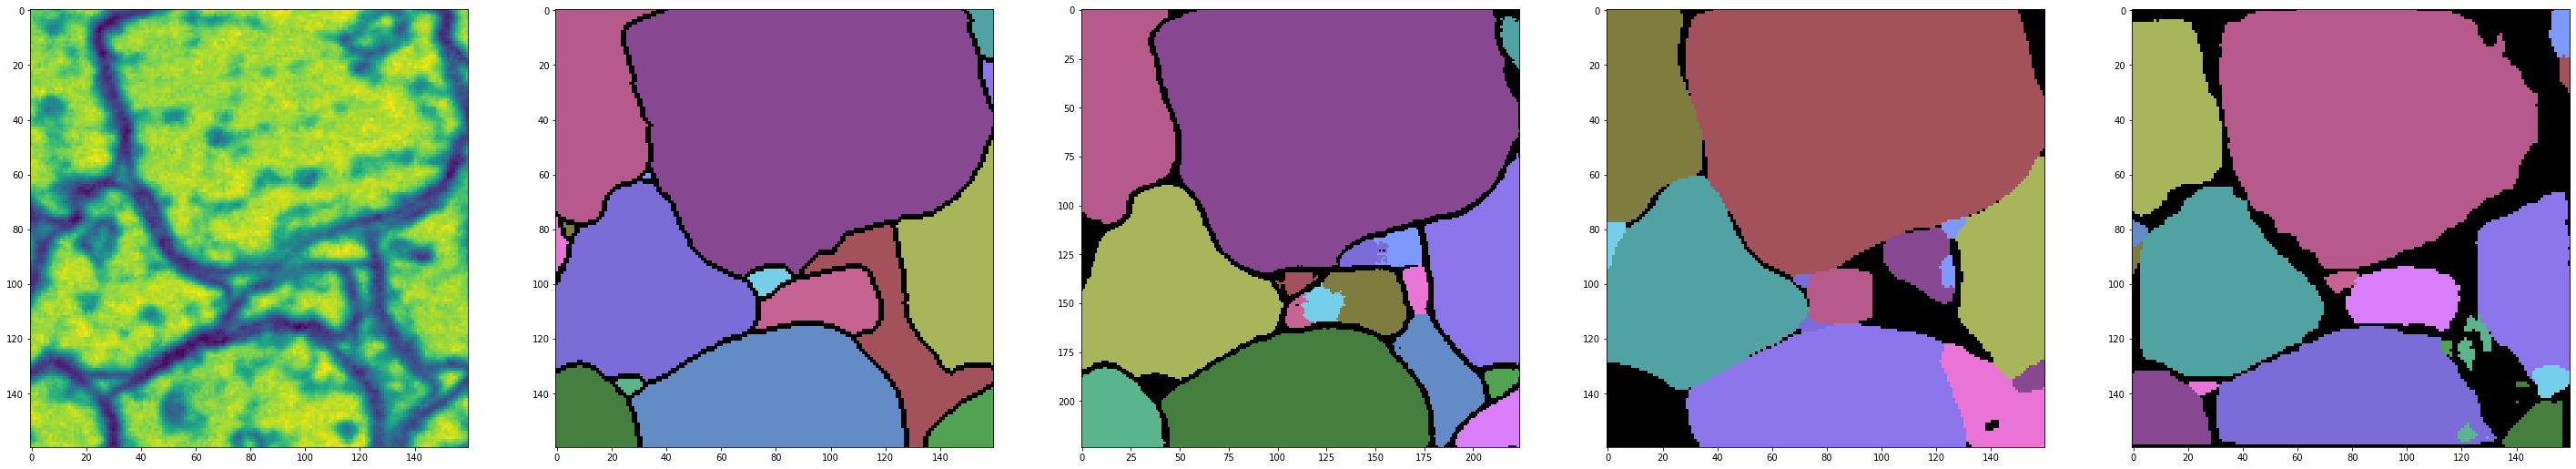

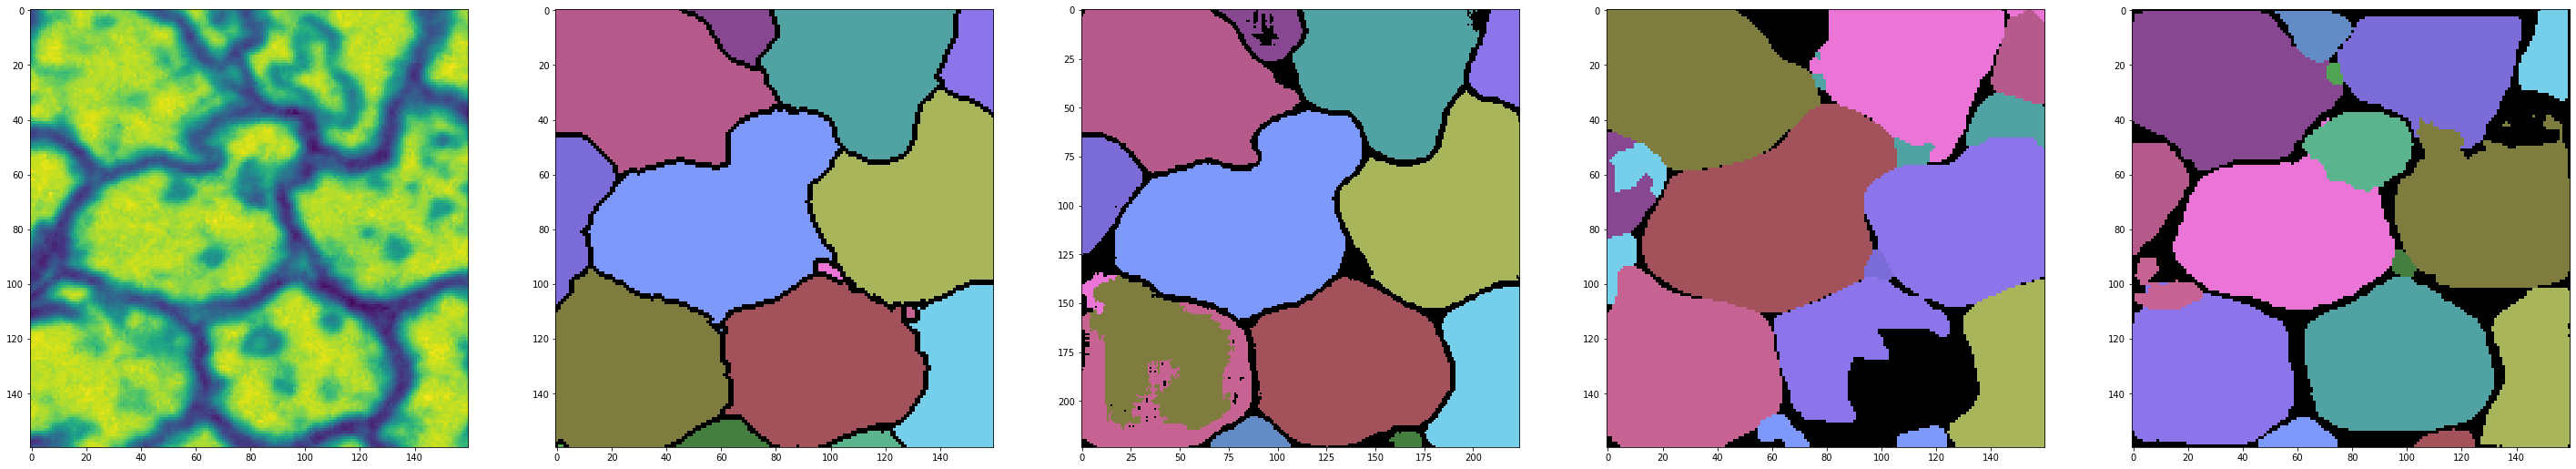

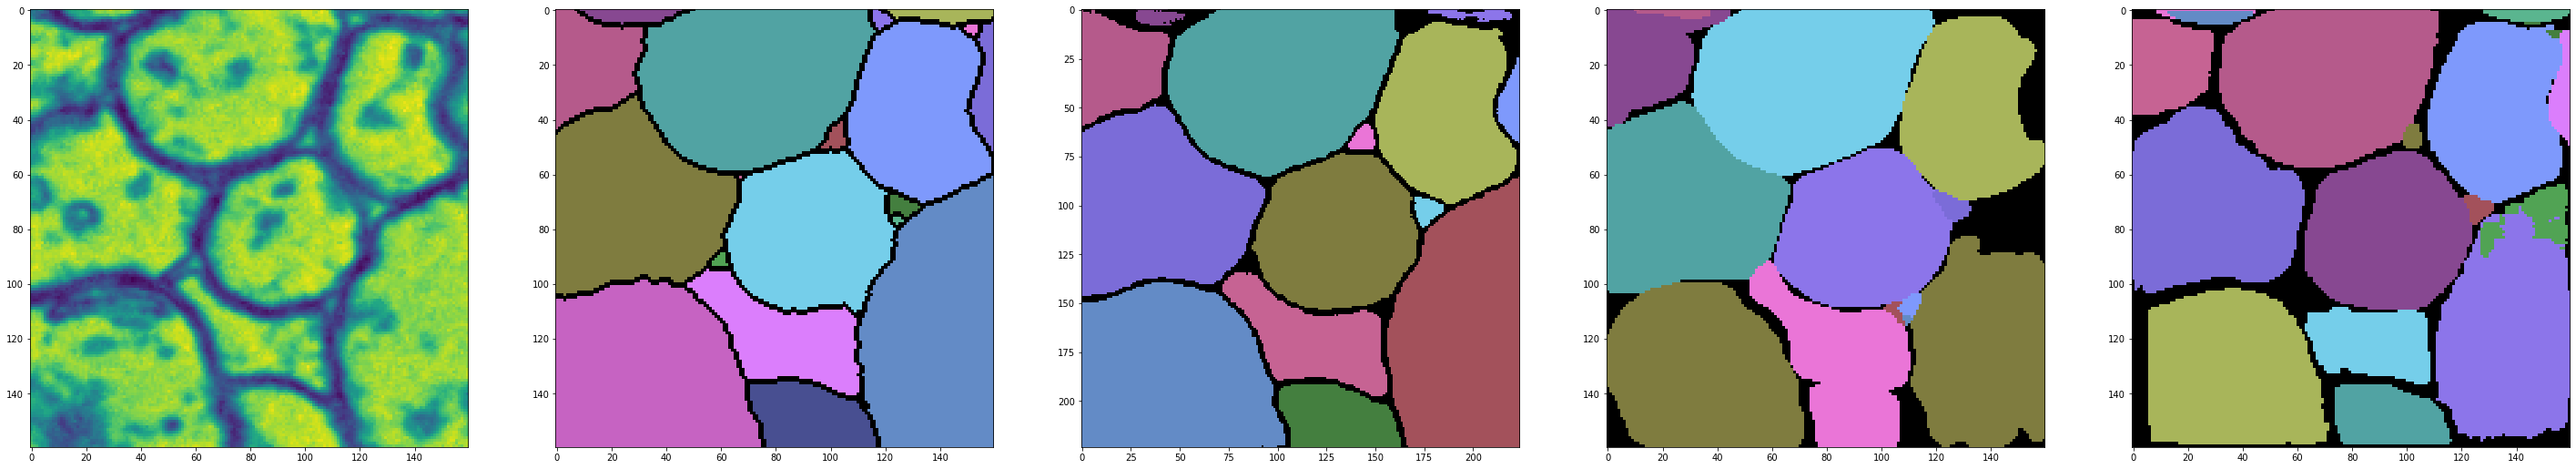

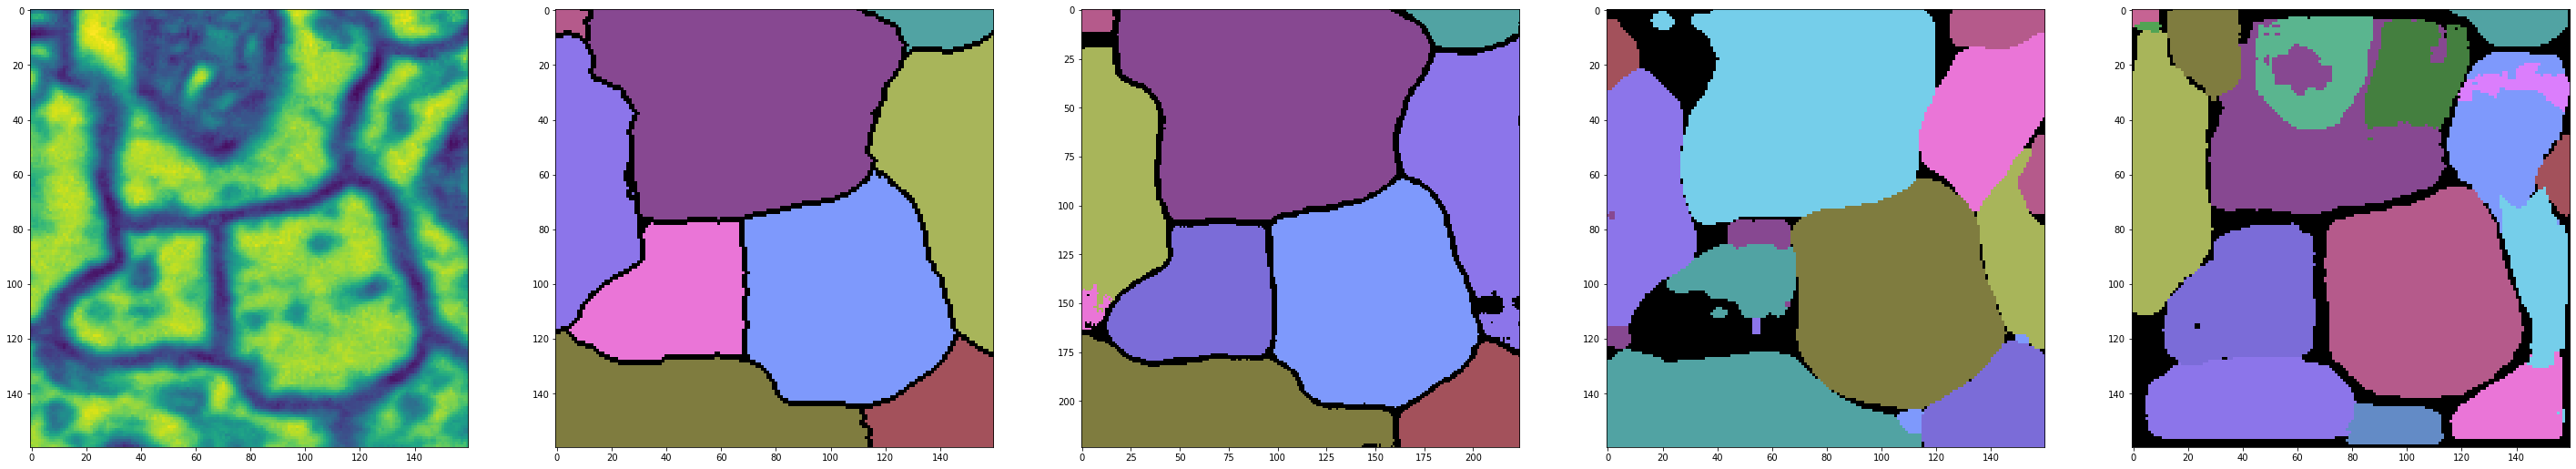

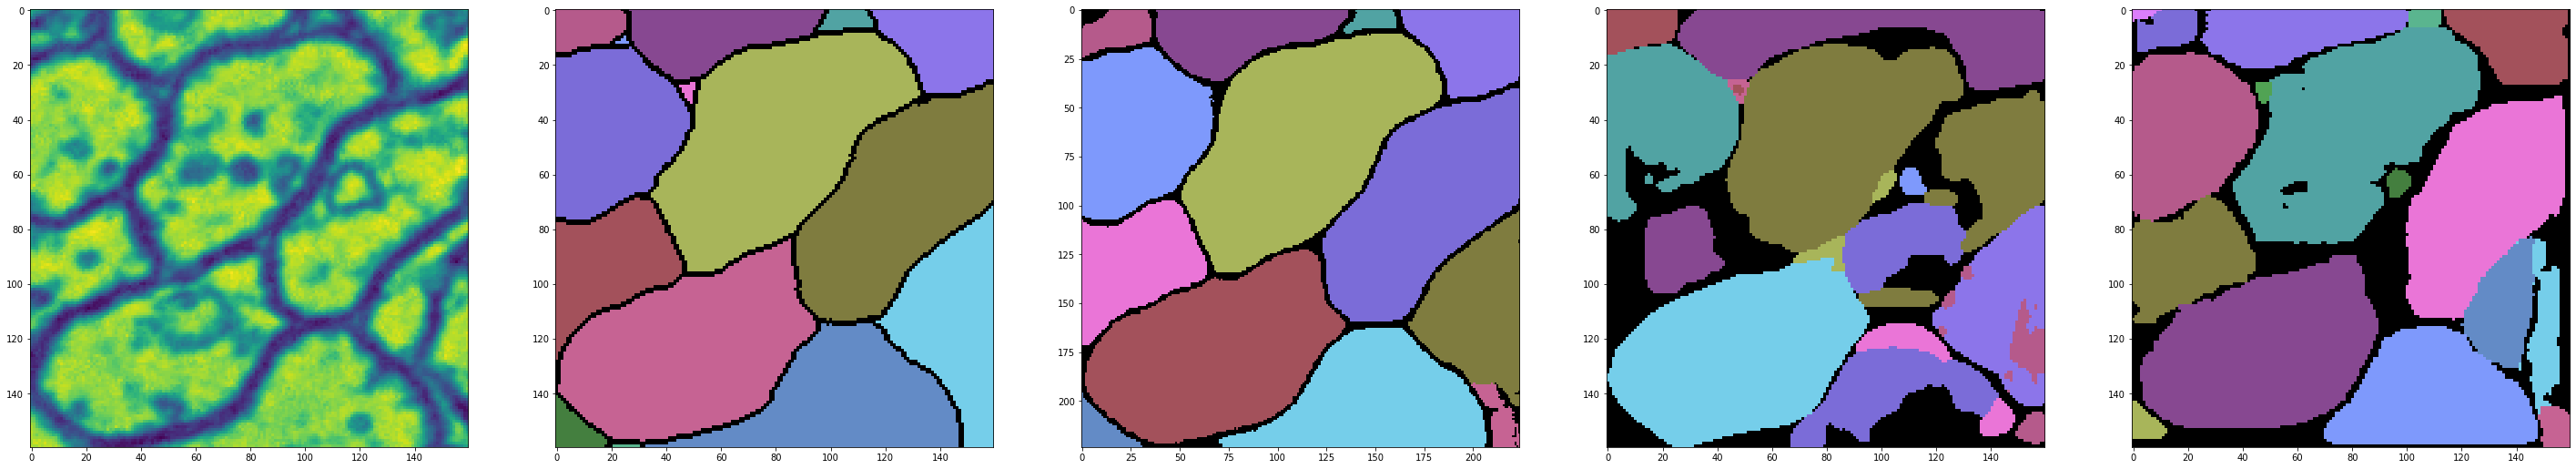

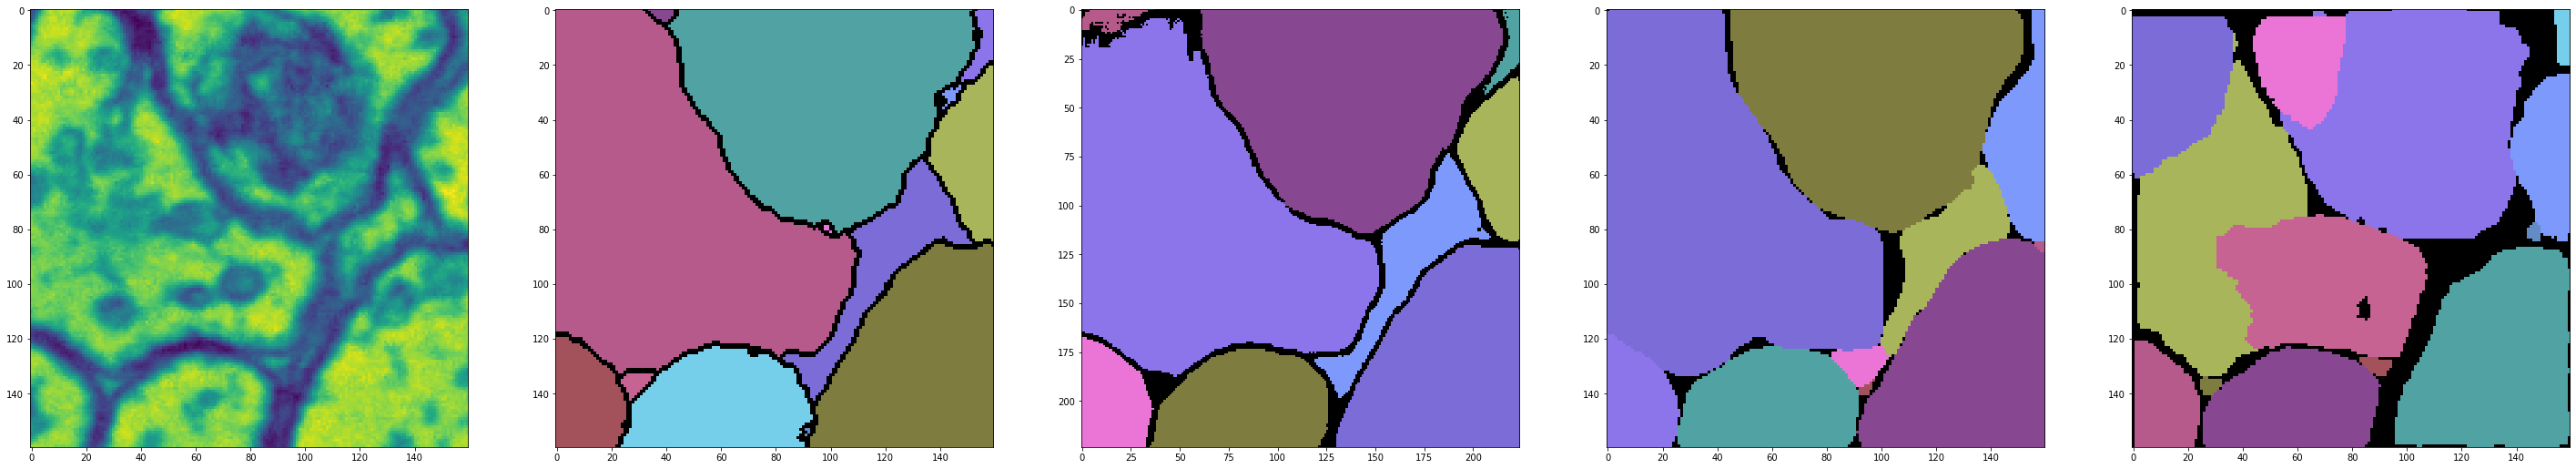

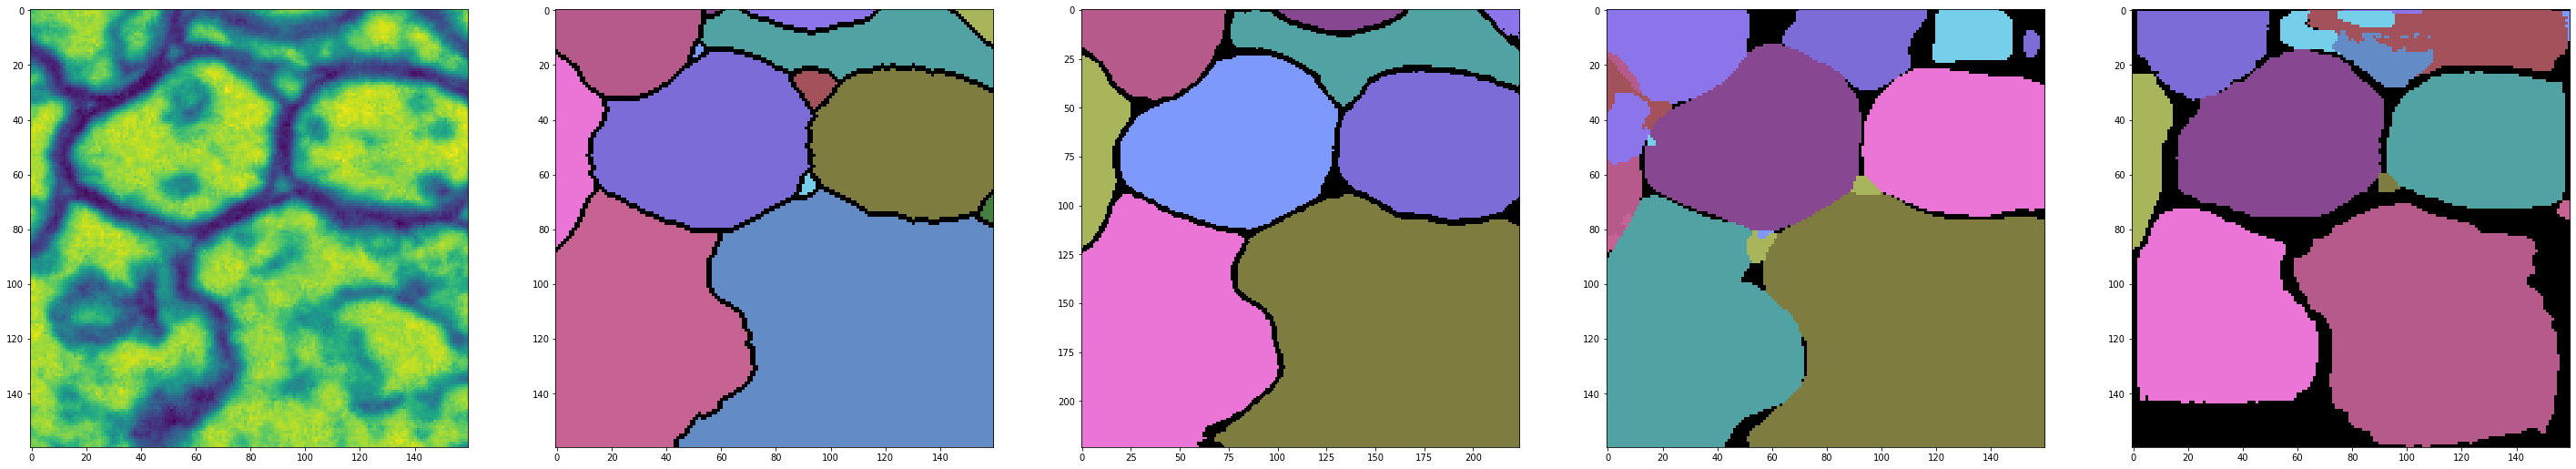

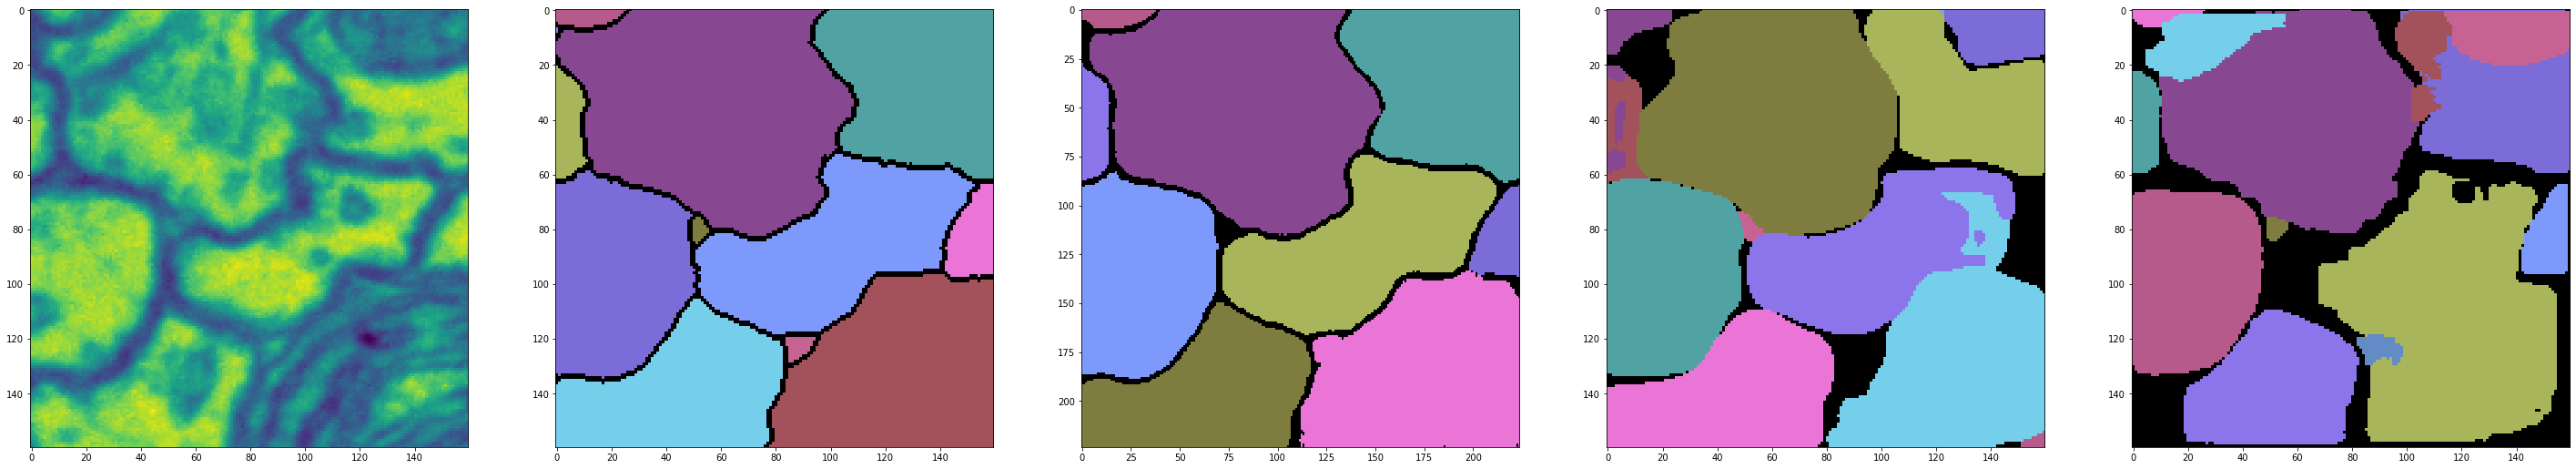

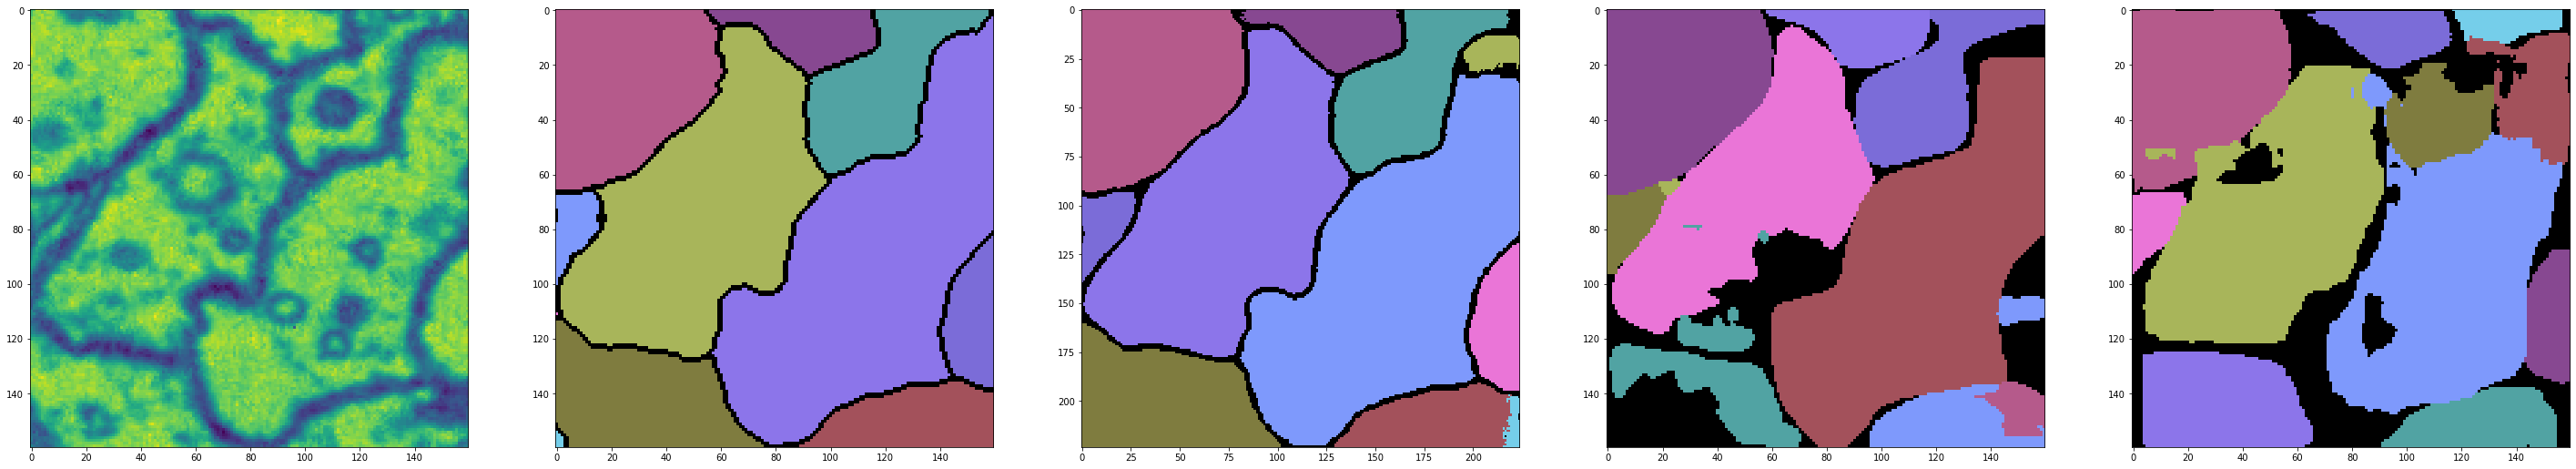

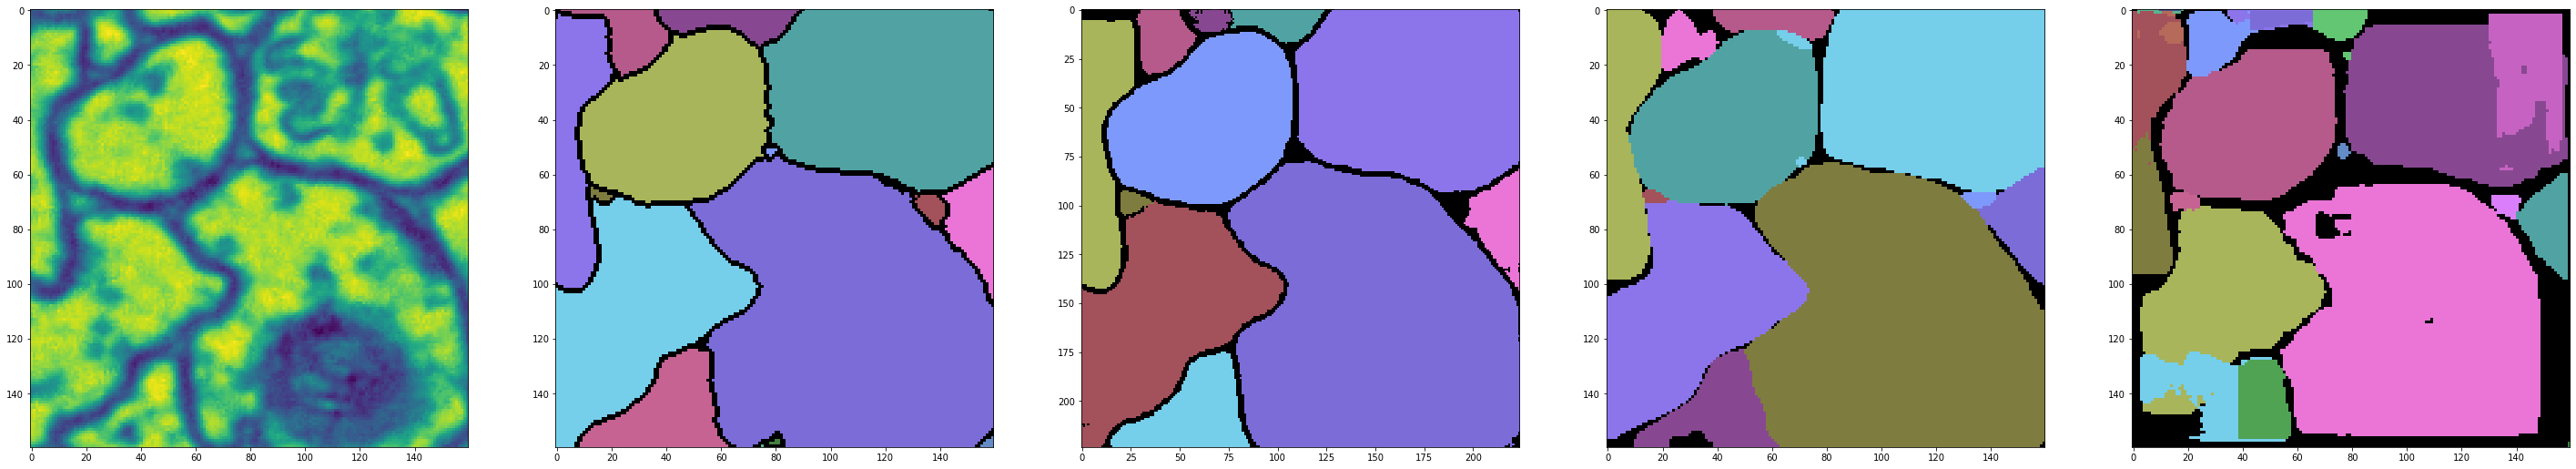

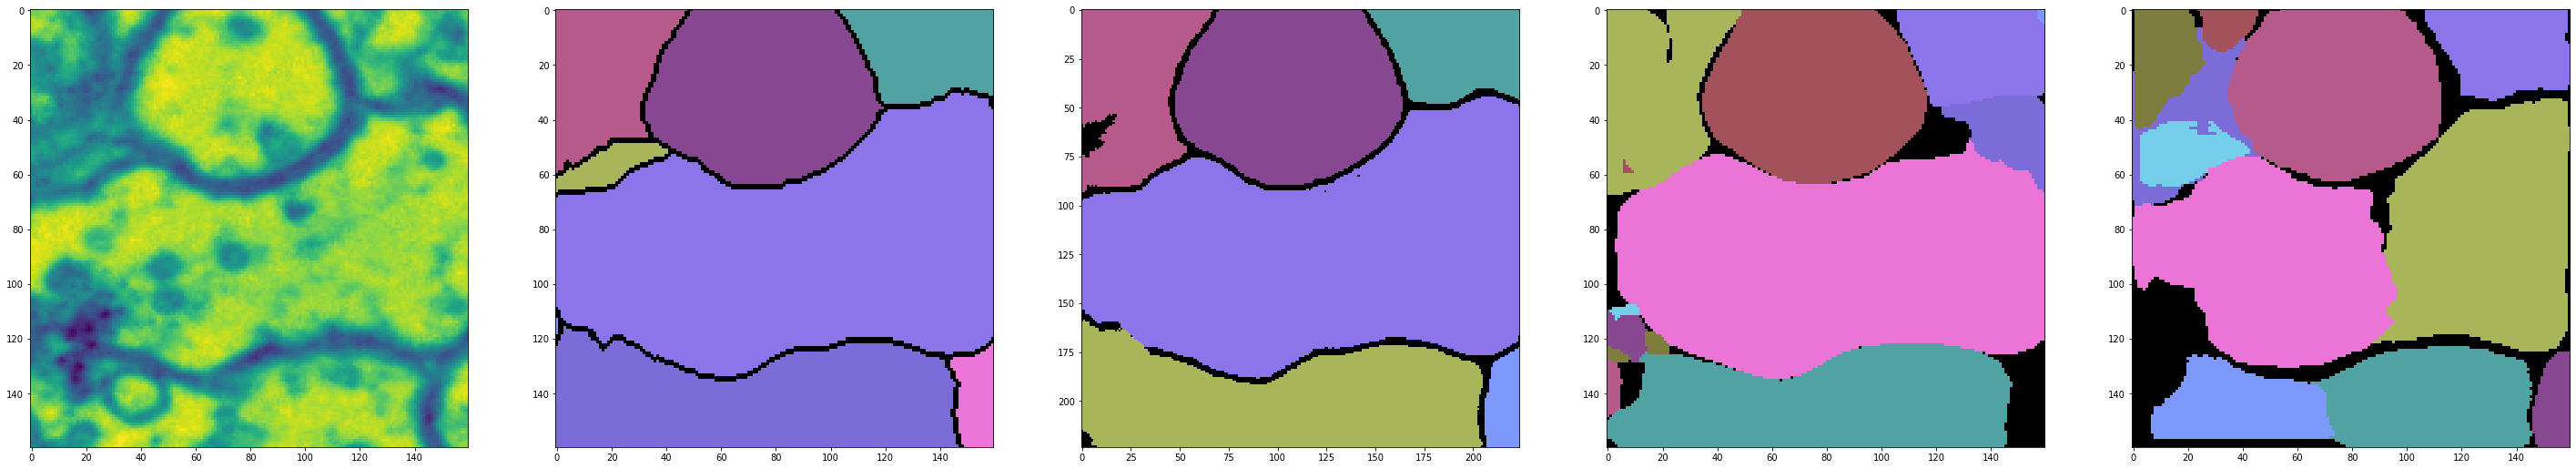

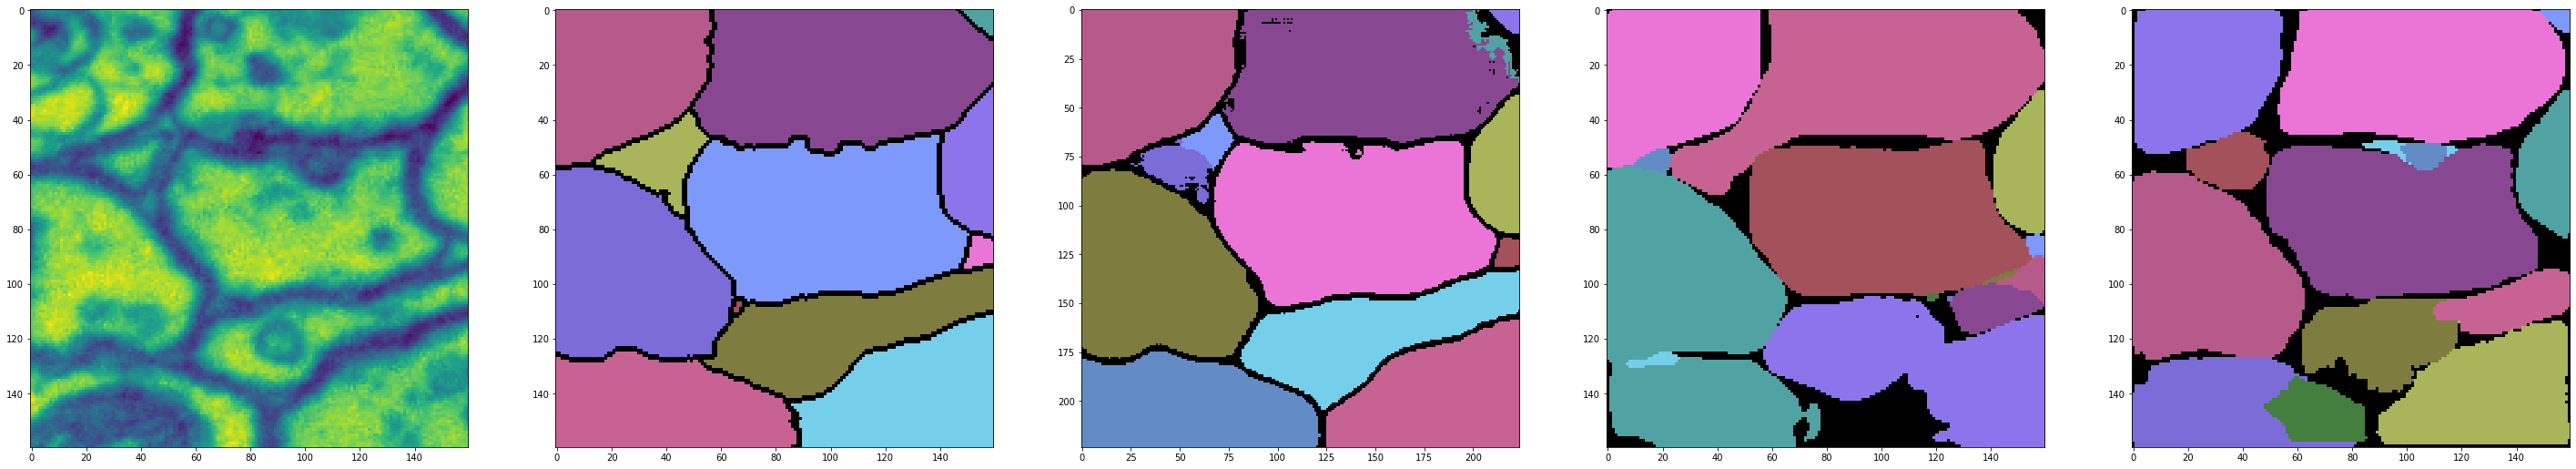

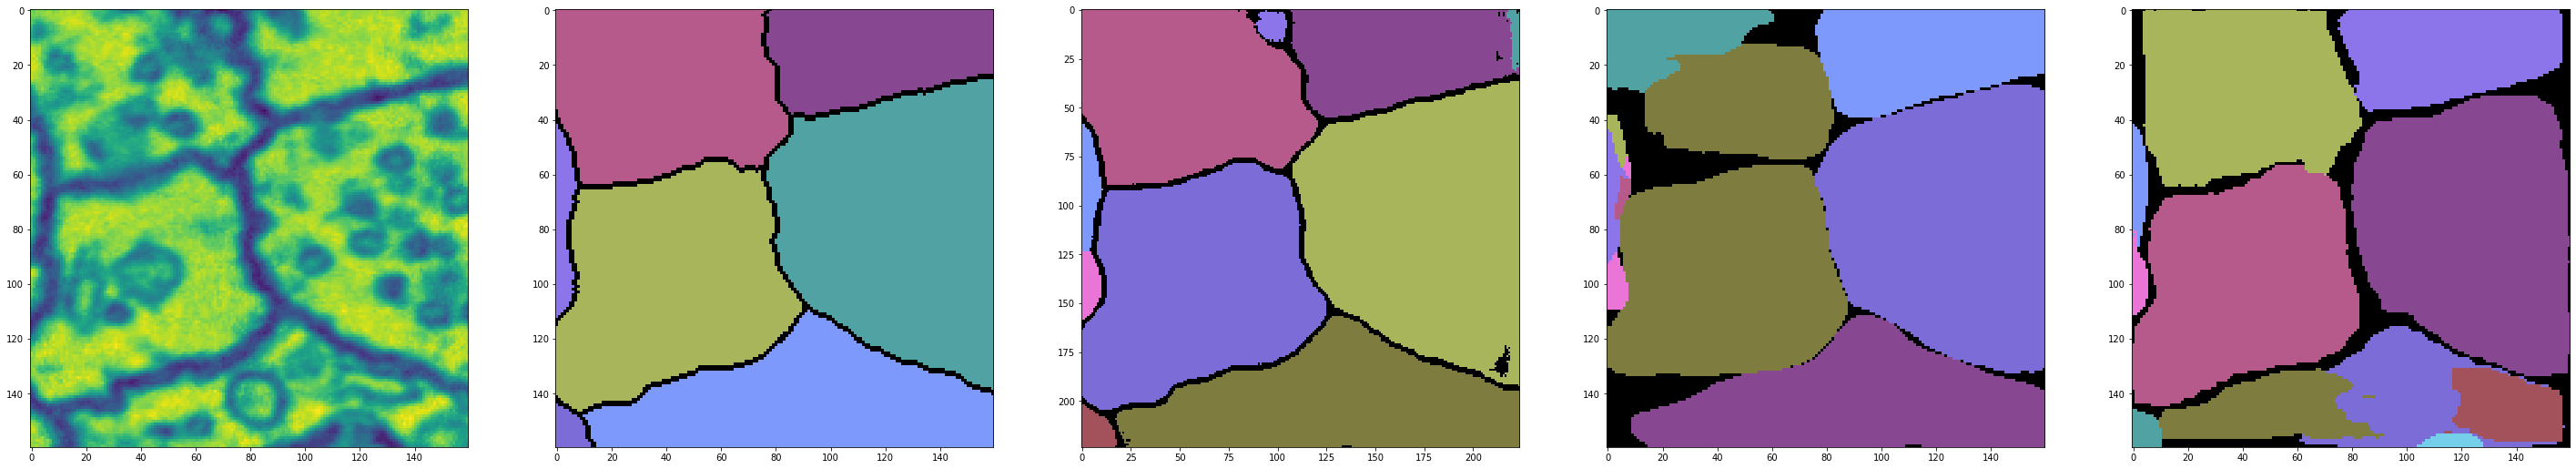

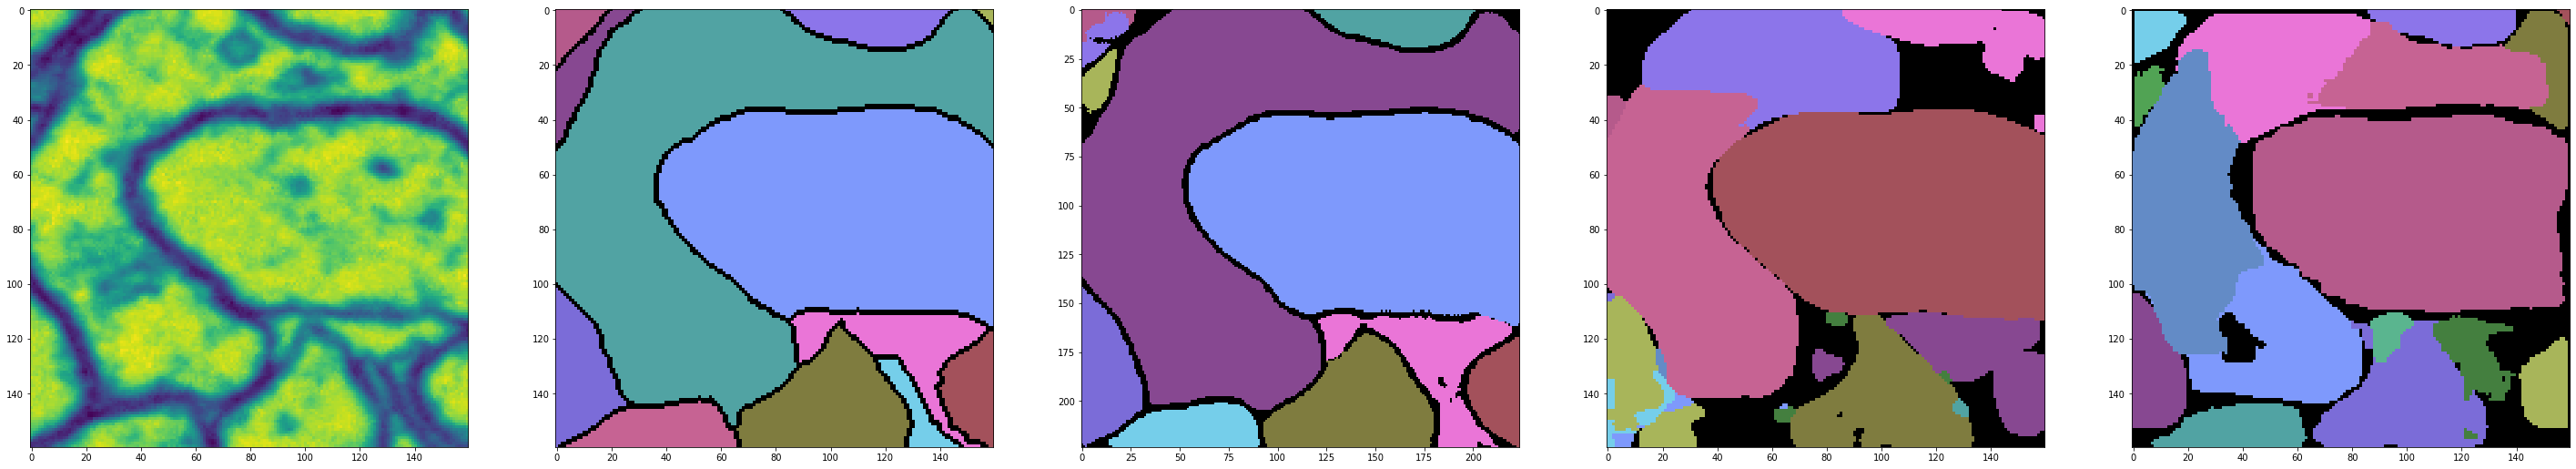

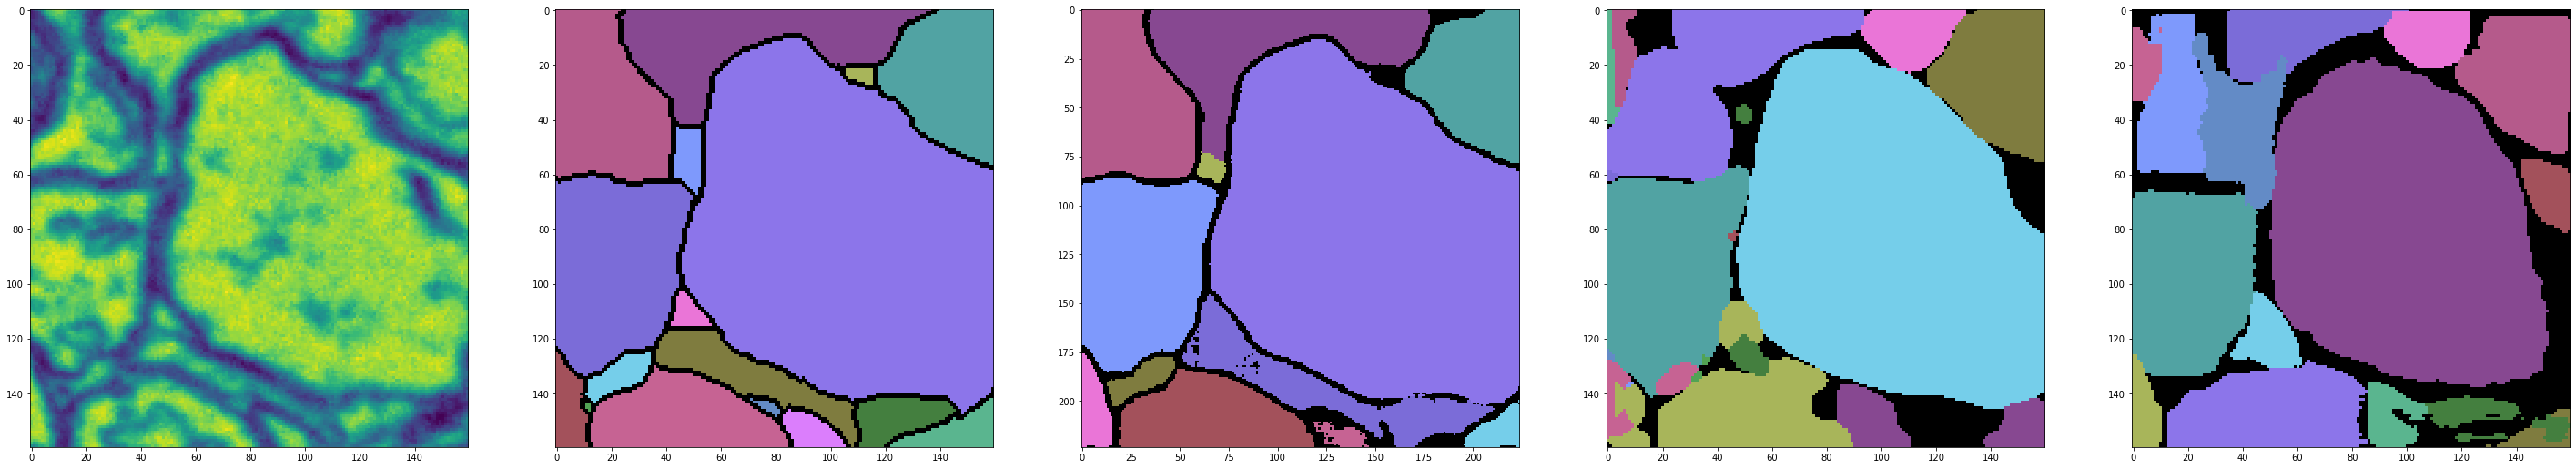

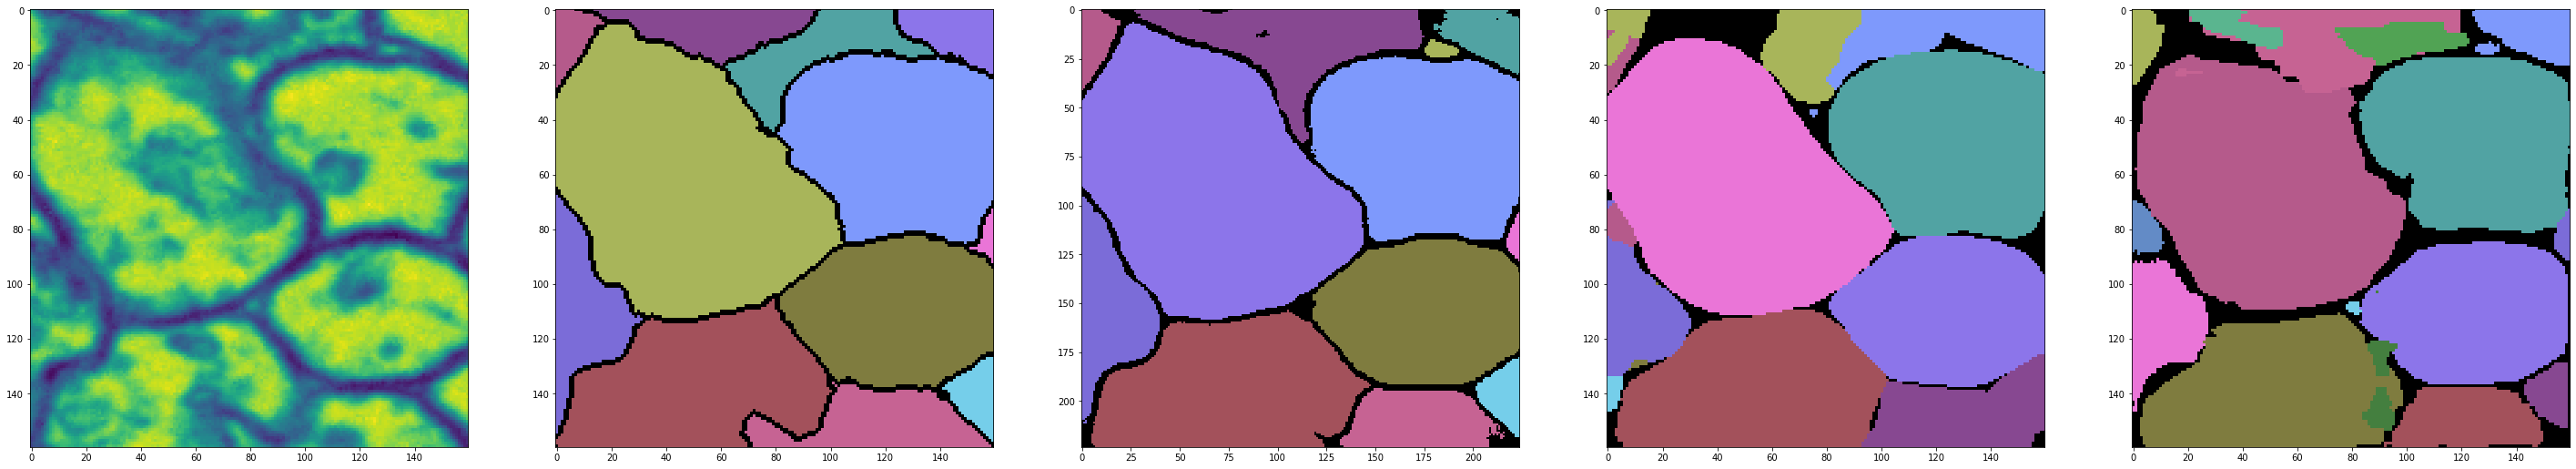

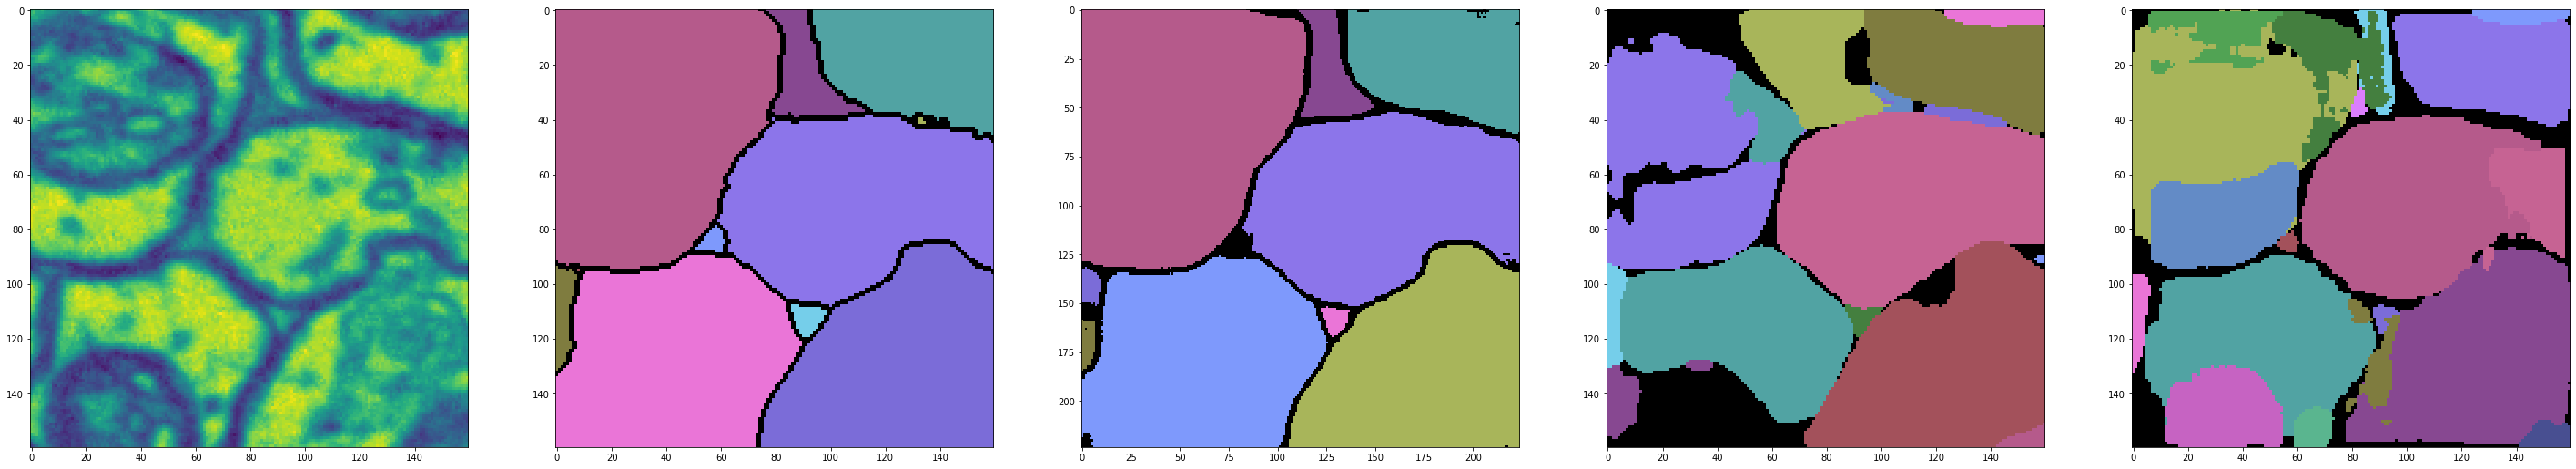

In [27]:
lbl2rgb = color_generator (100)
for idx in range (0, 25):
    fig, ax = plt.subplots (1,5, figsize=(50,15))
    ax [0].imshow (em [idx])
    ax [1].imshow (lbl2rgb (gt [idx]))
    ax [2].imshow (lbl2rgb (post_processed [idx]))
    ax [3].imshow (lbl2rgb (rec [idx]))
    ax [4].imshow (lbl2rgb (maskrcnn[idx]))
    plt.show ()

In [17]:
print (rec_path [0] )

/home/tuan/rec-attend-public-all/rec-cremi-160/results/full_model_cvppp-20200820105951/output_valid/30/plant148_label.png


In [28]:
result_dir = "160_cremi_results"
lbl2rgb = color_generator (100)
res = [acis, graphcl, rec, maskrcnn, gt, em]
meds = ["acis", "graphcl", "rec", "maskrcnn", "gt", "em"]
for med, lbl_lists in zip (meds, res):
    med_dir = result_dir + "/" + med + '/'
    os.makedirs (med_dir, exist_ok=True)
    if med in ['rec', 'acis', 'em']:
        continue
    
    for i in range (len_test):
        io.imsave (med_dir + '/' + str (i) + '.png', lbl2rgb (lbl_lists [i]))

for i in range (len_test):
    io.imsave (result_dir + '/em/' + str (i) + '.png', em[i])
        
acis_path = natsorted (glob ('/home/tuan/256_acis_master/eval/cvppp/results/*_label_c.png'))
for i in range (len_test):
    cmd = "cp " + acis_path [i] + ' ' + result_dir + '/acis/' + str (i) + '.png' 
    os.system (cmd)
    
rec_path = natsorted (glob ('/home/tuan/rec-attend-public-all/rec-cremi-160/results/full_model_cvppp-20200820105951/output_valid/30/*.png')) [:len_test]
for i in range (len (rec_path)):
    cmd = "cp " + rec_path [i] + ' ' + result_dir + '/rec/' + str (i) + '.png' 
    os.system (cmd)

Lossy conversion from int64 to uint8. Range [0, 252]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 252]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 252]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 252]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 252]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 252]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 252]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 252]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 